## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import seaborn as sns

from itertools import chain
from random import sample
import scipy

import skimage
import pydicom
from glob import glob

import sklearn.model_selection as skl
# from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, f1_score

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
72723,00017925_007.png,Effusion,7,17925,72,M,AP,2500,2048,0.168,0.168,NaN,/data/images_008/images/00017925_007.png
46091,00011804_013.png,Effusion|Emphysema|Mass,13,11804,56,M,PA,2992,2991,0.143,0.143,NaN,/data/images_006/images/00011804_013.png
1494,00000391_001.png,No Finding,1,391,76,F,PA,2048,2500,0.171,0.171,NaN,/data/images_001/images/00000391_001.png


In [3]:
all_xray_df.shape

(112120, 13)

In [4]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo

# based on Exploring Population Metadata Exercise SOlution (TO DO)
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split("|")))))
all_labels = [x for x in all_labels if len(x) > 0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels: 
    if len(c_label) > 1: 
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [5]:
all_xray_df.shape

(112120, 28)

In [6]:
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
Pneumonia_group_num = all_xray_df.Pneumonia.value_counts(normalize=False)
Pneumonia_group_dist = all_xray_df.Pneumonia.value_counts(normalize=True)
Pneumonia_group_dist = list(Pneumonia_group_dist)
print(Pneumonia_group_num)
Pneumonia_group_dist

0.0    110689
1.0      1431
Name: Pneumonia, dtype: int64


[0.9872368890474491, 0.012763110952550838]

In [8]:
all_xray_df['Pneumonia'].map(lambda x: True if x == 1.0 else False)

0         False
1         False
2         False
3         False
4         False
          ...  
112115     True
112116    False
112117    False
112118    False
112119    False
Name: Pneumonia, Length: 112120, dtype: bool

In [9]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x: "True" if x == 1.0 else "False")
# all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].astype('int')

In [10]:
all_xray_df['pneumonia_class'].value_counts()

False    110689
True       1431
Name: pneumonia_class, dtype: int64

In [11]:
# check the distribution to be the same as the Pneumonia column
pneumonia_class_dist = all_xray_df.pneumonia_class.value_counts(normalize=True)
Pneumonia_class_dist = list(pneumonia_class_dist)
Pneumonia_class_dist

Pneumonia_group_dist == Pneumonia_class_dist

True

In [12]:
#check the dataframe
all_xray_df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,False
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


## Create your training and testing data:

In [13]:
def create_splits(d, d_var, test_size = 0.2 ):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    
    """
    The function will take the following input dataframe (d) and disease condition 
    column (disease_var) to split the test_size percentage of the input data into 
    val_size and the remaining as training_size. The function will return `train_data` and `val_data`
    """
    train_data, val_data = skl.train_test_split(d, 
                                   test_size = test_size, 
                                   stratify = d[d_var])
    
    return train_data, val_data

In [14]:
train_df, valid_df = create_splits(all_xray_df, 'pneumonia_class', test_size = 0.2, )
print(all_xray_df.shape)
print(train_df.shape)
print(valid_df.shape)

(112120, 29)
(89696, 29)
(22424, 29)


In [15]:
valid_df['pneumonia_class'].value_counts()

False    22138
True       286
Name: pneumonia_class, dtype: int64

In [16]:
# check the valid % 
0.2 * 112120

22424.0

In [17]:
valid_df.pneumonia_class.value_counts(normalize=False)

False    22138
True       286
Name: pneumonia_class, dtype: int64

In [18]:
train_df.pneumonia_class.value_counts(normalize=False)

False    88551
True      1145
Name: pneumonia_class, dtype: int64

Let us now balance the `train_data` to have equal number of positive/negative cases for training

In [19]:
(all_xray_df['pneumonia_class'] == "True").value_counts()

False    110689
True       1431
Name: pneumonia_class, dtype: int64

In [20]:
# condition 1: To have equal positive and negative cases

t_p_inds  = train_df[train_df['pneumonia_class'] == "True"].index.tolist()
t_np_inds = train_df[train_df['pneumonia_class'] == "False"].index.tolist()

t_np_sample = sample(t_np_inds, len(t_p_inds))

# let us add the index to create a new balanced training set
train_df = train_df.loc[t_p_inds + t_np_sample ]


In [21]:
# condition 2: To have 1:4 positive cases as expected in real life for Pneumonia

v_p_inds  = valid_df[valid_df['pneumonia_class'] == "True"].index.tolist()
v_np_inds = valid_df[valid_df['pneumonia_class'] == "False"].index.tolist()

v_np_sample = sample(v_np_inds, 4*len(v_p_inds))

# let us add the index to create a new balanced training set
valid_df = valid_df.loc[v_p_inds + v_np_sample ]


In [22]:
train_df.shape

(2290, 29)

Final training and valid data set dimensions:

In [23]:
train_df['pneumonia_class'].value_counts()

False    1145
True     1145
Name: pneumonia_class, dtype: int64

In [24]:
valid_df['pneumonia_class'].value_counts()

False    1144
True      286
Name: pneumonia_class, dtype: int64

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [25]:
IMG_SIZE = (224, 224)
batch_size = 64

In [26]:
train_df.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
106598,00028764_003.png,Infiltration|Pneumonia,3,28764,24,F,PA,2021,2021,0.194314,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,True
68718,00016967_001.png,Pleural_Thickening|Pneumonia,1,16967,63,F,PA,2048,2500,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,True
70562,00017405_013.png,Pneumonia,13,17405,64,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
109405,00029763_004.png,Atelectasis|Infiltration|Pneumonia,4,29763,47,M,AP,3056,2544,0.139000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,True
16774,00004508_013.png,Atelectasis|Consolidation|Edema|Infiltration|P...,13,4508,37,M,AP,2500,2048,0.168000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,True


In [27]:
def my_image_augmentation(rescale_par = (1./255.0), h_flip = True, 
                         v_flip = False, h_shift_range = 0.1, 
                         w_shift_range = 0.1, r_range = 20, 
                         s_range = 0.1, z_range = 0.1):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    
    # note vertical_flip is not appropriate, so let us make it false
    
    my_idg = ImageDataGenerator(rescale= rescale_par,
                              horizontal_flip = h_flip, 
                              vertical_flip = v_flip, 
                              height_shift_range= h_shift_range, 
                              width_shift_range=w_shift_range, 
                              rotation_range=r_range, 
                              shear_range = s_range,
                              zoom_range=z_range)
    
    return my_idg


def make_train_gen(dataframe, x_col, y_col, class_mode, target_size,
                  batch_size = 9):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    #     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
    #                                          directory=None, 
    #                                          x_col = ,
    #                                          y_col = ,
    #                                          class_mode = 'binary',
    #                                          target_size = , 
    #                                          batch_size = 
    #                                          )
     # Todo
    
    train_gen = idg.flow_from_dataframe(dataframe=dataframe, 
                                         directory=None, 
                                         x_col = x_col,
                                         y_col = y_col,
                                         class_mode = class_mode,
                                         target_size = IMG_SIZE, 
                                         batch_size = batch_size
                                         )

    return train_gen

def make_val_gen(dataframe, x_col, y_col, 
                 class_mode = 'binary', target_size = IMG_SIZE, 
                 batch_size = batch_size):
    
    #     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
    #                                              directory=None, 
    #                                              x_col = ,
    #                                              y_col = ',
    #                                              class_mode = 'binary',
    #                                              target_size = , 
    #                                              batch_size = ) 
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = dataframe, 
                                             directory=None, 
                                             x_col = x_col,
                                             y_col = y_col,
                                             class_mode = class_mode,
                                             target_size = target_size, 
                                             batch_size = batch_size) 
    
    # Todo
    return val_gen

In [28]:
idg = my_image_augmentation()
train_gen = make_train_gen(dataframe=train_df, x_col = "path", 
               y_col = "pneumonia_class", 
               class_mode='binary', target_size=IMG_SIZE, 
               batch_size = batch_size)

Found 2290 validated image filenames belonging to 2 classes.


In [29]:
## May want to pull a single large batch of random validation data for testing after each epoch:
my_val_idg = ImageDataGenerator(rescale = 1./255.0)
val_gen = make_val_gen(dataframe = valid_df, x_col = "path", 
               y_col = "pneumonia_class", 
               class_mode='binary', target_size=IMG_SIZE, 
               batch_size = batch_size) 

Found 1430 validated image filenames belonging to 2 classes.


In [30]:
valX, valY = val_gen.next()

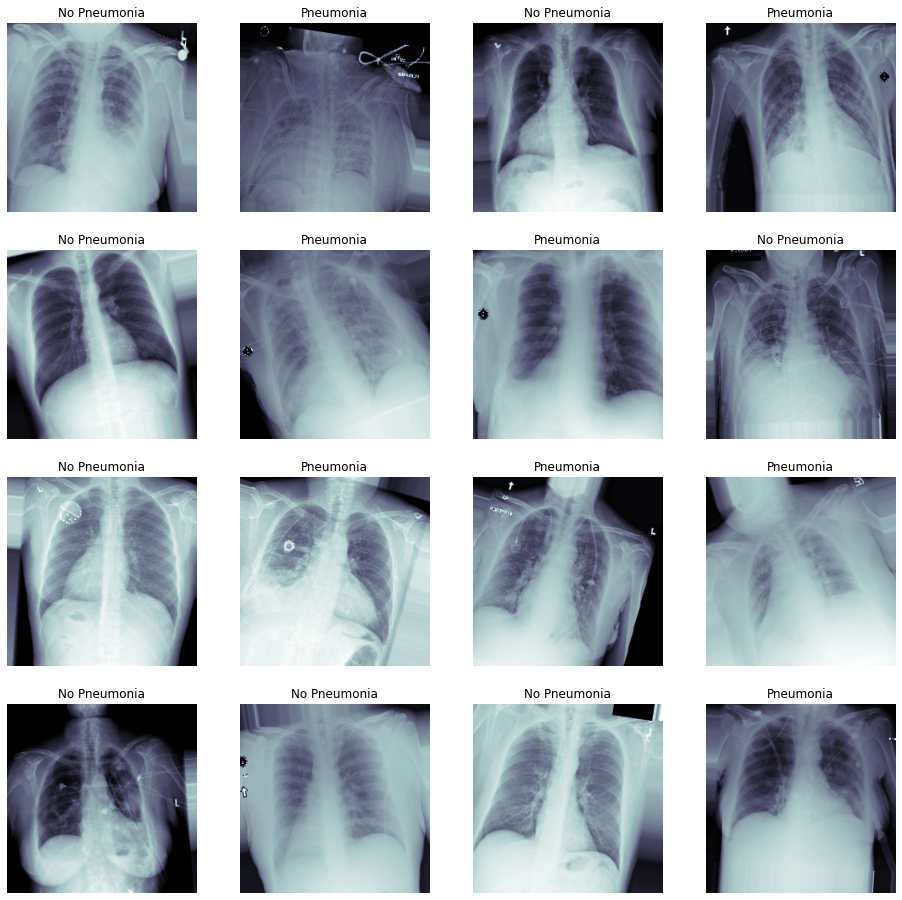

In [31]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [32]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    vgg_model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = vgg_model.get_layer('block5_pool')
    vgg_model = Model(inputs=vgg_model.input,
                   outputs=transfer_layer.output)
    
    return vgg_model


In [33]:
vgg_model = load_pretrained_model()
vgg_model.summary()

553467904/553467096 [==============================] - 39s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________

In [34]:
## Now, choose which layers of VGG16 we actually want to fine-tune (if any)
## Here, we'll freeze all but the last convolutional layer
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

In [35]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [36]:
def build_my_model(vgg_model):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, 
    # consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and 
    # metrics to monitor
    
    # Todo
    
    my_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    my_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    my_model.add(Flatten())
    
    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.05))
    
    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(1024, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.1))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(512, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.2))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(256, activation='relu'))
    
#     my_model.add(Dense(128, activation='relu'))
    
    my_model.add(Dropout(0.3))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(1, activation='sigmoid'))
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the 
## last classification layer of your modele to output class activation 
## maps to aid in clinical interpretation of your model's results

In [37]:
my_model = build_my_model(vgg_model)

for layer in my_model.layers:
    print(layer.name, layer.trainable)

model_1 True
flatten_1 True
dropout_1 True
dense_1 True
dropout_2 True
dense_2 True
dropout_3 True
dense_3 True
dropout_4 True
dense_4 True


In [38]:
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [39]:
## Set our optimizer, loss function, and learning rate
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [40]:
## Below is some helper code that will allow you to add checkpoints to 
## your model,
## This will save the 'best' version of your model by comparing it to 
## previous epochs of training

## Note that you need to choose which metric to monitor for your model's 
## 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will 
## train for ten epochs without seeing
## improvement before quitting

# Todo

# weight_path="{}_my_model.best.hdf5".format('xray_class')

# checkpoint = ModelCheckpoint(weight_path, 
#                              monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
#                              verbose=1, 
#                              save_best_only=True, 
#                              mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                              save_weights_only = True)

# early = EarlyStopping(monitor= SAME_AS_METRIC_CHOSEN_ABOVE, 
#                       mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                       patience=10)

# callbacks_list = [checkpoint, early]

weight_path="{}_my_model.best.hdf5".format('xray_class')
checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "min", 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= "min", 
                      patience=10)

callbacks_list = [checkpoint, early]


In [41]:
my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

### Start training! 

In [42]:
## train your model

# Todo

# history = my_model.fit_generator(train_gen, 
#                           validation_data = (valX, valY), 
#                           epochs = , 
#                           callbacks = callbacks_list)

history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 10, 
                          callbacks = callbacks_list)

Epoch 1/10
36/36 [==============================] - 78s 2s/step - loss: 0.7246 - binary_accuracy: 0.5367 - val_loss: 0.5804 - val_binary_accuracy: 0.7656

Epoch 00001: val_loss improved from inf to 0.58042, saving model to xray_class_my_model.best.hdf5
Epoch 2/10
36/36 [==============================] - 76s 2s/step - loss: 0.6867 - binary_accuracy: 0.5672 - val_loss: 0.6377 - val_binary_accuracy: 0.6094

Epoch 00002: val_loss did not improve from 0.58042
Epoch 3/10
36/36 [==============================] - 82s 2s/step - loss: 0.6768 - binary_accuracy: 0.5773 - val_loss: 0.7095 - val_binary_accuracy: 0.5625

Epoch 00003: val_loss did not improve from 0.58042
Epoch 4/10
36/36 [==============================] - 64s 2s/step - loss: 0.6688 - binary_accuracy: 0.6057 - val_loss: 0.6858 - val_binary_accuracy: 0.5625

Epoch 00004: val_loss did not improve from 0.58042
Epoch 5/10
36/36 [==============================] - 62s 2s/step - loss: 0.6574 - binary_accuracy: 0.6066 - val_loss: 0.6549 - val

##### Let us look at the model performance by plotting some performance statistics:

These figures will come in handy for the FDA documentation discussed later in the project

In [43]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

64/64 [==============================] - 4s 59ms/step


In [44]:
pred_Y[0:10]

array([[0.3735218 ],
       [0.33619848],
       [0.38852307],
       [0.31708202],
       [0.27595475],
       [0.4813848 ],
       [0.47672248],
       [0.301287  ],
       [0.4101687 ],
       [0.33679703]], dtype=float32)

In [45]:
pred_Y.shape

(64, 1)

In [52]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    auc = roc_auc_score(t_y, p_y)
    
    plt.plot(fpr, tpr, label='Pneumonia (AUC: {:.3f})'.format(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title("AUC Curve")
    plt.legend(['Pneumonia (AUC: {:.3f})'.format(auc)], loc='lower right')
    plt.show()
    
    return thresholds

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo
def plot_precession_recall(t_y, p_y):
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    plt.plot(recall, precision , label='Pneumonia')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.title("Precision-Recall Curve")
    plt.legend(['Pneumonia'], loc='upper right')
    plt.show()

    return precision, recall, thresholds

    

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    return

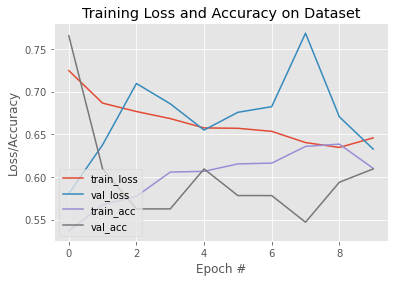

In [53]:
## plot figures

# Todo
plot_history(history)

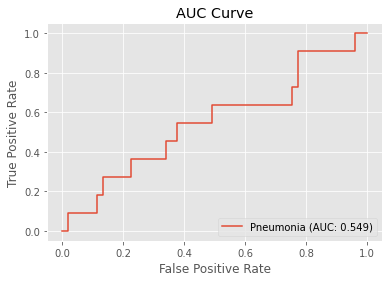

array([1.5926112 , 0.5926112 , 0.5419627 , 0.48364246, 0.48304725,
       0.48199278, 0.4813848 , 0.4525792 , 0.43968883, 0.42497945,
       0.42454422, 0.4138828 , 0.41145137, 0.40271708, 0.40252814,
       0.34474066, 0.34222063, 0.33959058, 0.33619848, 0.301287  ,
       0.29268152, 0.2696049 ], dtype=float32)

In [54]:
plot_auc(valY, pred_Y)

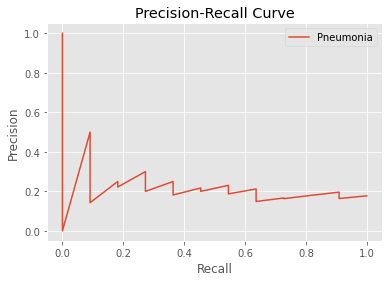

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [55]:
precision, recall, thresholds = plot_precession_recall(valY, pred_Y)
precision = np.array(precision)
recall = np.array(recall)
f1_score = 2 * (precision*recall)/(precision+recall)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [56]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. 
## Make sure you take all your metrics into consideration.

# Todo

#Let us use f1_score 
maxF1 = max(f1_score)
print("Max F1 Score:", maxF1)
threshold = thresholds[f1_score.argmax()]
print("Threshold based on max-F1-Score", threshold)

Max F1 Score: 0.3243243243243243
Threshold based on max-F1-Score 0.5926112


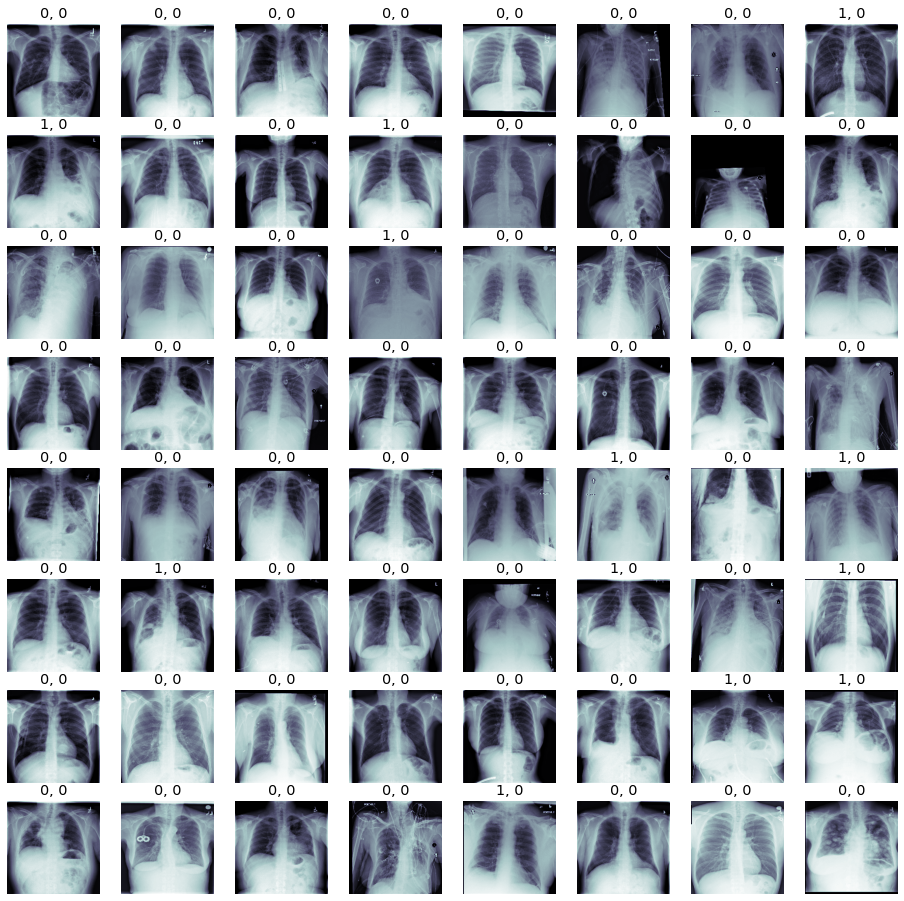

In [57]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

testX, testY = val_gen.next()

fig, m_axs = plt.subplots(8, 8, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [58]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)